In [1]:
from langchain_ollama import ChatOllama
model = ChatOllama(model='gemma3:1b', temperature=0)

In [ ]:
from pydantic import BaseModel
from typing import List, Literal

class Answer(BaseModel):
    response: Literal["Yes", "No"]

model_yn = model.with_structured_output(Answer)

In [4]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

prompt = """You are given a query / task. If you understand the query / have knowledge about the topic, return a 'Yes'.
If you don't have clarity on the asked topic / query, simply return a 'No'.
"""

model_yn.invoke([SystemMessage(content=prompt), HumanMessage(content = "Do you know about lkjdl")])

Answer(response='No')

In [ ]:
from langgraph.graph import MessagesState, START, END, StateGraph
from typing import Literal, List, Annotated
import operator

class State(MessagesState):
    answers: Annotated[List[Literal["Yes", "No"]], operator.add]
    problems: Annotated[list[str], operator.add]
    solutions: Annotated[list[str], operator.add]
    final_ans: str

In [6]:
class Solutions(BaseModel):
    solutions: List[str]


solutions_model = model.with_structured_output(Solutions)

In [10]:
def assistant(state):
    prompt = """You are given a query / task. If you understand the query / have knowledge about the topic, return a 'Yes'.
    If you don't have clarity on the asked topic / query, simply return a 'No'.
    """
    response = model_yn.invoke([SystemMessage(content=prompt), state['messages'][-1]])
    return({'answers':[response.response]})

def check(state) -> Literal['solution_planner', 'fallback']:
    if(state['answers'][-1] == 'Yes'):
        return "solution_planner"
    elif(state['answers'][-1] == 'No'):
        return 'fallback'
    
def fallback(state):
    user_value = input(f"Can you rephrase your question '{state['messages'][-1]}': ")

    prompt = """You are given a query / task. If you understand the query / have knowledge about the topic, return a 'Yes'.
    If you don't have clarity on the asked topic / query, simply return a 'No'.
    """
    response = model_yn.invoke([SystemMessage(content=prompt), user_value])

    return ({'messages': HumanMessage(content=user_value), 'answers': [response.response]})

def solution_planner(state):
    prompt = '''You are a problem solving planner. You are given a query / task by the user. 
    You have to break the problem down into smaller problems, and return all the smaller problems. 
    Each smaller problem statement should be as small as possible, and all of them combined should totally cover the whole problem.
    '''

    solutions = solutions_model.invoke([SystemMessage(content=prompt), state['messages'][-1]])
    return ({'problems': solutions.solutions})

In [11]:
builder = StateGraph(State)

builder.add_node("assistant", assistant)
builder.add_node('fallback', fallback)
builder.add_node('solution_planner', solution_planner)

builder.add_edge(START, 'assistant')
builder.add_conditional_edges('assistant', check)
builder.add_conditional_edges('fallback', check)
builder.add_edge("solution_planner", END)

graph = builder.compile()

In [13]:
from langchain_core.messages import HumanMessage

In [14]:
graph.invoke({'messages': HumanMessage(content='what is the capital of france?')})

{'messages': [HumanMessage(content='what is the capital of france?', additional_kwargs={}, response_metadata={}, id='72bb9ff5-27d9-4873-b296-23d58d4bf054')],
 'answers': ['Yes'],
 'problems': ['Identify the country: France',
  'Determine the capital city of France: Paris'],
 'solutions': []}

## Now with Map Reduce

In [58]:
class State(MessagesState):
    answers: Annotated[List[Literal["Yes", "No"]], operator.add]
    problems: list
    solutions: Annotated[list, operator.add]
    final_ans: str

In [47]:
from langgraph.types import Send

In [54]:
from typing import TypedDict

class SolvingState(TypedDict):
    # messages: list  # if you're passing chat history through state
    what: str

In [78]:
def assistant(state):
    prompt = """You are given a query / task. If you understand the query / have knowledge about the topic, return a 'Yes'.
    If you don't have clarity on the asked topic / query, simply return a 'No'.
    """
    response = model_yn.invoke([SystemMessage(content=prompt), state['messages'][-1]])
    return({'answers':[response.response]})

def check(state) -> Literal['solution_planner', 'fallback']:
    if(state['answers'][-1] == 'Yes'):
        return "solution_planner"
    elif(state['answers'][-1] == 'No'):
        return 'fallback'
    
def fallback(state):
    user_value = input(f"Can you rephrase your question '{state['messages'][-1]}': ")

    prompt = """You are given a query / task. If you understand the query / have knowledge about the topic, return a 'Yes'.
    If you don't have clarity on the asked topic / query, simply return a 'No'.
    """
    response = model_yn.invoke([SystemMessage(content=prompt), user_value])

    return ({'messages': HumanMessage(content=user_value), 'answers': [response.response]})

def solution_planner(state):
    prompt = '''You are a problem solving planner. You are given a query / task by the user. 
    You have to break the problem down into smaller problems, and return all the smaller problems. 
    Each smaller problem statement should be as small as possible, and all of them combined should totally cover the whole problem.
    '''

    solutions = solutions_model.invoke([SystemMessage(content=prompt), state['messages'][-1]])
    return ({'problems': solutions.solutions})

def reduce1(state):
    return [
        Send("solving_node", {**state, "problems": p})
        for p in state["problems"]
    ]
    

def solving_node(state: SolvingState):
    print("Solving Node")
    prompt = """You are a problem solver. Given the main problem statement, and a smaller part of the problem, 
    You are to solve the SMALLER part of the problem in max 30 words.
    """
    human_prompt = f"""Problem Statement: "{state['messages'][-1].content}"
    Smaller Problem: 
    """
    
    answer = model.invoke([SystemMessage(content=prompt), HumanMessage(content=human_prompt)])
    return ({'solutions': [answer.content]})

In [ ]:
builder = StateGraph(State)

builder.add_node("assistant", assistant)
builder.add_node('fallback', fallback)
builder.add_node('solution_planner', solution_planner)
builder.add_node('solving_node', solving_node)i

builder.add_edge(START, 'assistant')
builder.add_conditional_edges('assistant', check)
builder.add_conditional_edges('fallback', check)
builder.add_conditional_edges("solution_planner", reduce1, ["solving_node"])
builder.add_edge('solving_node', END)

graph = builder.compile()

In [80]:
graph.invoke({'messages': HumanMessage(content='what is the capital of france?')})

Solving Node
Solving Node


{'messages': [HumanMessage(content='what is the capital of france?', additional_kwargs={}, response_metadata={}, id='5ade2ef0-186e-4b85-8c85-eee3c86a7bb1')],
 'answers': ['Yes'],
 'problems': ['Identify the country: France',
  'Determine the capital city of France: Paris'],
 'solutions': ['Paris is the capital of France.',
  'Paris is the capital of France.']}

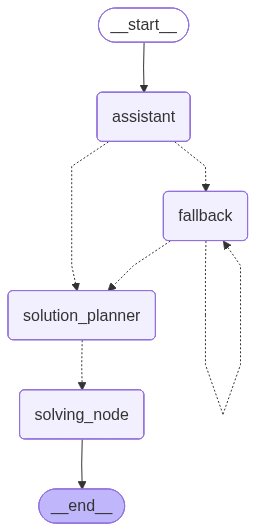

In [81]:
builder.compile()